# Proyecto 1 — Pokémon Data Science Pipeline

**Dataset:** Pokémon (721 observaciones)

---

## Objetivo del proyecto
Construir un **pipeline completo de ciencia de datos** que permita:

1. Explorar y limpiar datos reales
2. Identificar patrones mediante clustering
3. Visualizar datos en baja dimensión (PCA)
4. Construir un modelo supervisado para predecir el poder ofensivo (`Attack`)
5. Publicar el proyecto en GitHub como parte de un portafolio académico


## ¿Qué es un pipeline de ciencia de datos?

Un pipeline es una **secuencia ordenada y reproducible de pasos**, típicamente:

1. Obtención de datos
2. Exploración (EDA)
3. Limpieza e imputación
4. Transformación de variables
5. Modelado
6. Evaluación
7. Comunicación de resultados

Este notebook sigue explícitamente esa estructura.


1. ¿Existen familias naturales de pokemon segun sus stats?
2. ¿Qué variables explican mejor el poder ofensivo de un okemon?
3. ¿podemos predecir el Attack (o base_experience) a partir de sus características?

## 1) Obtención de datos desde Kaggle

Kaggle es una plataforma que:
- aloja datasets reales
- permite competencias y proyectos
- es ampliamente usada en portafolios profesionales

Hoy importaremos los datos **directamente desde Kaggle**, sin descargas manuales.


### Configuración de Kaggle API en Colab

Pasos:
1. Crear una cuenta en Kaggle
2. Ir a *Account* → *Create API Token*
3. Subir el archivo `kaggle.json` a este entorno

Este archivo contiene credenciales personales.
**Nunca debe subirse a GitHub.**


In [2]:
!pip -q install kaggle

In [3]:
!pip -q install ydata-profiling # para analisis de datos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.7 MB/s eta 0:00:00


In [4]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from ydata_profiling import ProfileReport

In [5]:
kaggle_creds = {
    "username": "token",
    "key": "KGAT_14071bc393a686537a2787e3c2d03850"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)

## Data access
This project uses data from Kaggle.
To reproduce the results, configure Kaggle API credentials
following Kaggle's official documentation.

In [6]:
!kaggle datasets download -d abcsds/pokemon

Dataset URL: https://www.kaggle.com/datasets/abcsds/pokemon
License(s): CC0-1.0
  0% 0.00/14.9k [00:00<?, ?B/s]
100% 14.9k/14.9k [00:00<00:00, 32.7MB/s]


In [7]:
!kaggle datasets download -d abcsds/pokemon
!unzip pokemon.zip

Dataset URL: https://www.kaggle.com/datasets/abcsds/pokemon
License(s): CC0-1.0
pokemon.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pokemon.zip
  inflating: Pokemon.csv             


In [8]:
df = pd.read_csv("Pokemon.csv")
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


## 2) Exploración inicial del dataset

Variables principales:
- Type 1, Type 2: tipos del Pokémon
- HP, Attack, Defense, Sp. Atk, Sp. Def, Speed: estadísticas base
- Total: suma de estadísticas (indicador global de poder)

Comenzamos con una exploración básica.

EDA MANUAL

In [9]:
df.shape

(800, 13)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [11]:
df.isna().sum()

,0
#,0
Name,0
Type 1,0
Type 2,386
Total,0
HP,0
Attack,0
Defense,0
Sp. Atk,0
Sp. Def,0


Gráficas
histograma
Caja
Correlación

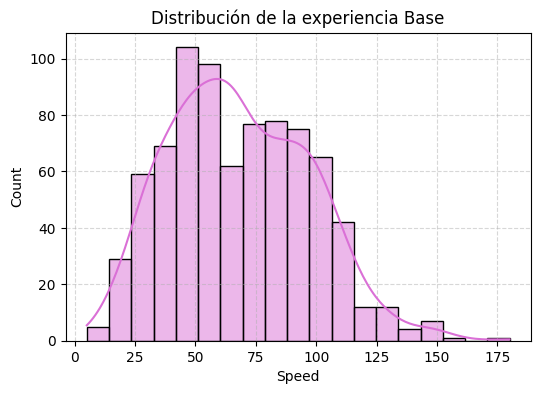

In [12]:
# Pokemon histograma por velocidad
plt.figure(figsize = (6,4))
sns.histplot()
sns.histplot(x = 'Speed',
             data = df,
             bins = 'auto',
             kde = True, # Curva de densidad
             color = 'orchid')
plt.title('Distribución de la experiencia Base')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.show()

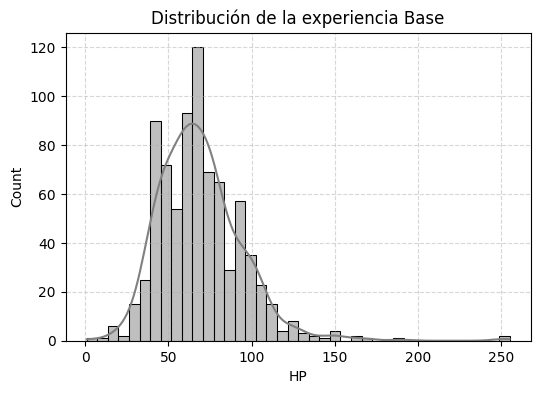

In [13]:
# Pokemon histograma por HP
plt.figure(figsize = (6,4))
sns.histplot()
sns.histplot(x = 'HP',
             data = df,
             bins = 'auto',
             kde = True, # Curva de densidad
             color = 'gray')
plt.title('Distribución de la experiencia Base')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.show()

In [14]:
tipos = df.groupby('Type 1')['Defense'].median().sort_values().index
tipos

Index(['Bug', 'Normal', 'Fire', 'Electric', 'Psychic', 'Grass', 'Fairy',
       'Poison', 'Dark', 'Fighting', 'Water', 'Ghost', 'Ice', 'Flying',
       'Ground', 'Dragon', 'Rock', 'Steel'],
      dtype='object', name='Type 1')

Text(0.5, 1.0, 'Altura de los Pokemones según el tipo')

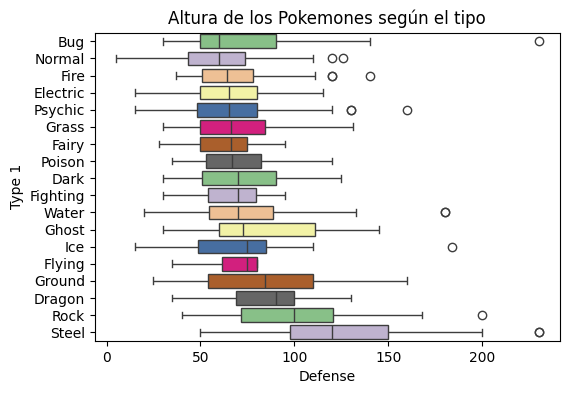

In [15]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(6,4))
sns.boxplot(y = 'Type 1',
            x = 'Defense',
            data = df,
            order = tipos,
            palette = 'Accent')
plt.title('Altura de los Pokemones según el tipo')

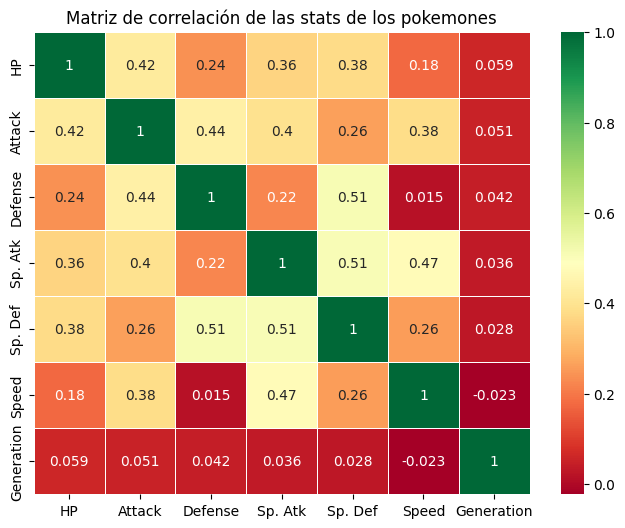

In [16]:
# correlación de los datos
corr_matriz = df[['HP','Attack','Defense','Sp. Atk',
                  'Sp. Def','Speed','Generation']].corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr_matriz, annot = True, cmap = 'RdYlGn', linewidths = 0.5)
plt.title('Matriz de correlación de las stats de los pokemones')
plt.show()

EDA ONLINE

In [17]:
# profile = ProfileReport(
#     df,
#     title = 'Pokemon EDA',
#     explorative = True
# )

In [18]:
# profile

In [1]:
#profile.to_file("pokemon_eda_report.html")

## 3) Limpieza e imputación

La variable `Type 2` tiene valores faltantes porque:
- muchos Pokémon tienen un solo tipo

Estrategia:
- imputar los valores faltantes con la categoría `"None"`

Esto preserva la información y evita errores posteriores.

In [19]:
df['Type 2'] = df['Type 2'].fillna('None')

## 4) Clustering no supervisado

Queremos explorar si existen **grupos naturales de Pokémon**
basados únicamente en sus estadísticas.

Usaremos:
- KMeans para agrupar
- PCA para visualizar

In [20]:
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
X = df[features].values # pasa a tipo numpy
type(X)

numpy.ndarray

Estandarización

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.95062622, -0.92490618, -0.79715364, -0.2391303 , -0.24818854,
        -0.80150318],
       [-0.3628221 , -0.5241302 , -0.34791742,  0.21955954,  0.29115635,
        -0.28501525],
       [ 0.42091674,  0.09244823,  0.29384863,  0.83114599,  1.01028289,
         0.40363531],
       ...,
       [ 0.42091674,  0.95565803, -0.44418232,  2.36011211,  2.08897269,
         0.05931003],
       [ 0.42091674,  2.49710411, -0.44418232,  2.97169856,  2.08897269,
         0.40363531],
       [ 0.42091674,  0.95565803,  1.4811158 ,  1.74852566,  0.65071962,
         0.05931003]])

Elbow Method

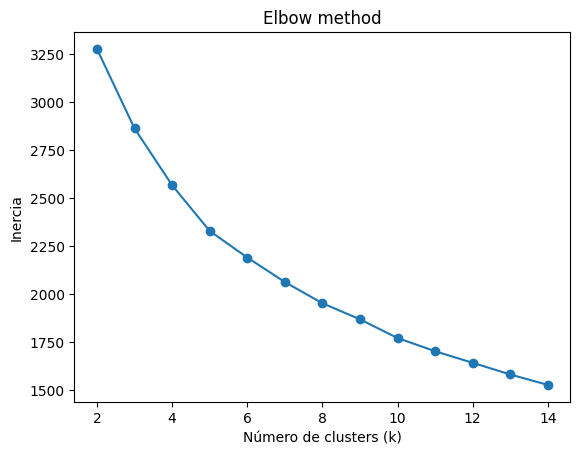

In [22]:
inertia = []
K = range(2, 15)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Elbow method")
plt.show()

K-means

In [23]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
clusters = kmeans.fit_predict(X_scaled)

In [24]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

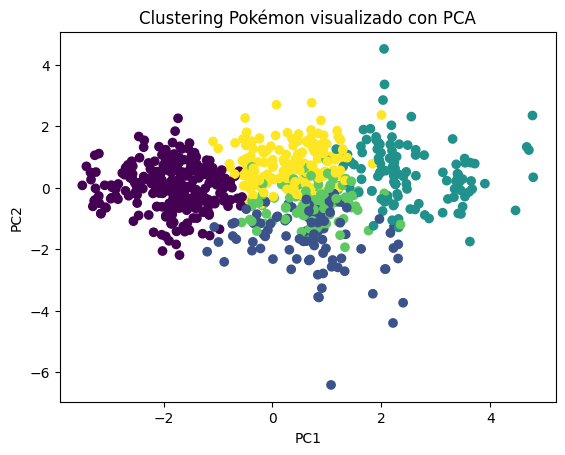

In [25]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clustering Pokémon visualizado con PCA")
plt.show()

In [26]:
import plotly.express as px
labels = kmeans.fit_predict(X_scaled)
# 2) PCA a 3 componentes
pca3 = PCA(n_components=3, random_state=42)
X_3d = pca3.fit_transform(X_scaled)

print("Varianza explicada (3 componentes):", round(pca3.explained_variance_ratio_.sum(), 4))

# 3) DataFrame para visualización (si tienes df con Name/Type, úsalo para hover)
viz = pd.DataFrame({
    "PC1": X_3d[:, 0],
    "PC2": X_3d[:, 1],
    "PC3": X_3d[:, 2],
    "cluster": labels
})

# Si existe df y tiene columnas útiles, agrégalas para hover (opcional)
# Ajusta nombres de columnas si difieren
if "df" in globals():
    for col in ["Name", "Type 1", "Type 2", "Attack", "Defense", "Speed", "HP", "Total"]:
        if col in df.columns:
            viz[col] = df[col].values

hover_cols = [c for c in ["Type 1", "Type 2", "Attack", "Defense", "Speed", "HP", "Total"] if c in viz.columns]

fig = px.scatter_3d(
    viz,
    x="PC1", y="PC2", z="PC3",
    color="cluster",
    hover_name="Name" if "Name" in viz.columns else None,
    hover_data=hover_cols,
    title="Clusterización (KMeans) visualizada con PCA 3D — interactivo"
)

fig.update_traces(marker=dict(size=4))
fig.show()

Varianza explicada (3 componentes): 0.764


## 5) Aprendizaje supervisado

Ahora construiremos un modelo para **predecir el Attack**
usando:
- estadísticas base
- tipo principal (Type 1)

Esto requiere:
- codificar variables categóricas
- separar train/test
- evaluar desempeño

In [27]:
cat = df[['Type 1']]
num = df[['HP', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]

In [28]:
encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(cat)

In [29]:
X_all = np.hstack([num.values, X_cat])

In [30]:
y = df["Attack"].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

In [32]:
model = LinearRegression()
model.fit(X_train, y_train) # entrenamiento del modelo

LinearRegression()

In [33]:
# predicción
y_pred = model.predict(X_test)

In [34]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print("R2:",r2)
print("RMSE", rmse)

R2: 0.5037366278757756
RMSE 536.9847089855009


Segundo modelo con las variables de mayor correlación

In [35]:
X2 = df[['HP', 'Defense']].values

In [36]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [37]:
model2 = LinearRegression()
model2.fit(X2_train, y2_train) # entrenamiento del modelo
y2_pred = model2.predict(X2_test)

In [38]:
R2 = r2_score(y2_test, y2_pred)
mse2 = mean_squared_error(y2_test, y2_pred)
print("R2:",R2)
print("RMSE", mse2)

R2: 0.28557643985523706
RMSE 773.0462272373586


Otro método más robust

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs = -1
)

In [40]:
rf.fit(X2_train, y2_train)
yrf_pred = rf.predict(X2_test)

In [41]:
R2 = r2_score(y2_test, yrf_pred)
mse2 = mean_squared_error(y2_test, yrf_pred)
print("R2:",R2)
print("RMSE", mse2)

R2: 0.24650056644672802
RMSE 815.328506545633


## 6) Publicación del proyecto en GitHub

GitHub es:
- un repositorio de código
- una vitrina profesional
- un historial de tu trabajo

Un buen proyecto debe incluir:
- notebooks claros
- estructura ordenada
- un README explicativo

### Estructura recomendada

pokemon-project/
├── data/        (opcional, si el dataset es liviano)
├── notebooks/
│   └── pokemon_analysis.ipynb
├── figures/
├── README.md


# Pokémon Data Science Project

## Objective
Analyze Pokémon statistics to identify patterns and predict offensive power.

## Dataset
Source: Kaggle — Pokémon Dataset (800 Pokémon)

## Methods
- EDA
- Missing value imputation
- KMeans clustering + PCA
- Linear Regression
- Random Forest

## Results
- Identified clusters of similar Pokémon
- Built a regression model to predict Attack (it doesn't work)

## Tools
Python, Pandas, NumPy, Scikit-learn

## Author
Juan Felipe Valencia Buitrago